Train a lightweight, causal GRU-based Voice Activity Detection (VAD) system suitable for real-time hearing-aid applications.

In [1]:
!pip install -r ../../requirements.txt

  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached cffi-2.0.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.6 kB)
  Using cached contourpy-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached fonttools-4.58.5-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (106 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached Gammatone-1.0.3-py3-none-any.whl.metadata (6.6 kB)
  Using cached inflate64-1.0.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached jams-0.3.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl.metadata (2.9 k

In [2]:
# %% ------------------------- Cell 1: Imports & Setup ------------------------
import sys
from pathlib import Path
import torch, torch.nn as nn, torch.nn.functional as F
import torchaudio, numpy as np, random
from tqdm.notebook import tqdm

SEED = 0
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

current_dir = Path.cwd()
repo_root = current_dir.parent.parent
sys.path.insert(0, str(repo_root / "src"))

print("Repo root:", repo_root)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# helper utils
from utils.audio_dataset_loader import (
    load_ears_dataset, load_wham_dataset, load_noizeus_dataset,
    create_audio_pairs, preprocess_audio
)

Repo root: /home/sagemaker-user/PROJECT-25P85
Using device: cuda


In [3]:
# %% ------------------------- Cell 2: Global Plot Settings -------------------------
import matplotlib.pyplot as plt

# Set global plot parameters
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

print("[INFO] Global plot settings applied: DPI=400")

[INFO] Global plot settings applied: DPI=400


In [4]:
class TinyGRUVAD(nn.Module):
    """Light GRU-based VAD, causal, hearing-aid friendly (~2 k params)."""
    def __init__(self, input_dim=32, hidden_dim=16, dropout=0.1):
        super().__init__()
        
        self.pre = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=0, groups=input_dim)
        self.norm = nn.LayerNorm(input_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, h=None):
        # x: (B,T,F)
        x = x.transpose(1,2)              # (B,F,T)
        # causal pad: pad (kernel_size-1) frames on the left only so conv doesn't see future frames
        k = self.pre.kernel_size[0] if isinstance(self.pre.kernel_size, (list, tuple)) else self.pre.kernel_size
        pad_left = k - 1
        x = F.pad(x, (pad_left, 0))       # pad on time dimension (left, right)
        x = self.pre(x).transpose(1,2)    # local causal conv
        x = self.norm(x)
        out, h = self.gru(x, h)
        out = self.drop(out)
        # return raw logits (B,T,1); use BCEWithLogitsLoss for stability
        logits = self.fc(out)
        return logits, h


In [5]:
# %% ------------------------- Cell 3: Load Datasets --------------------------
max_pairs = 900
noise_files = load_wham_dataset(repo_root, mode="train", max_files=max_pairs)
clean_files = load_ears_dataset(repo_root, mode="train")
train_pairs = create_audio_pairs(noise_files, clean_files)
print(f"Train pairs: {len(train_pairs)}")

noise_val = load_wham_dataset(repo_root, mode="validation", max_files=193)
clean_val = load_ears_dataset(repo_root, mode="validation")
val_pairs = create_audio_pairs(noise_val, clean_val)
print(f"Val pairs: {len(val_pairs)}")

# Load TEST set (for final evaluation - never used during training)
noise_test = load_wham_dataset(repo_root, mode="test", max_files=193)
clean_test = load_ears_dataset(repo_root, mode="test")
test_pairs = create_audio_pairs(noise_test, clean_test)
print(f"Test pairs: {len(test_pairs)}")
print("\n [WARN] TEST SET: Only use for final evaluation, NOT during training/validation!")

Limited WHAM dataset to 900 files for train mode


/home/sagemaker-user/PROJECT-25P85/src/utils/audio_dataset_loader.py:62: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(f)
/opt/conda/lib/python3.12/site-packages/torchaudio/_backend/soundfile_backend.py:120: UserWarning: torchaudio._backend.common.AudioMetaData has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 r

Created 900 audio pairs
Train pairs: 900
Limited WHAM dataset to 193 files for validation mode
Created 193 audio pairs
Val pairs: 193
Limited WHAM dataset to 193 files for test mode
Created 193 audio pairs
Test pairs: 193

 [WARN] TEST SET: Only use for final evaluation, NOT during training/validation!


In [6]:
def minimum_statistics_noise_floor(energy, window_size=50, subwindow_size=10):
    """Estimate noise floor using Minimum Statistics approach (Martin 2001).
    
    This is the GOLD STANDARD for noise floor estimation in VAD systems.
    Used in ITU-T G.729B, AMR codecs, and commercial hearing aids.
    
    Algorithm:
    1. Divide signal into overlapping windows
    2. Find minimum in each subwindow (assumes some non-speech periods)
    3. Smooth minimums over time (noise varies slowly)
    
    Reference:
    - Martin, R. (2001). "Noise power spectral density estimation based on 
      optimal smoothing and minimum statistics." IEEE Trans. Speech Audio Process.
    
    Args:
        energy: Frame-level energy (T,) tensor
        window_size: Search window in frames (~2 seconds at 250 fps)
        subwindow_size: Subwindow for local minimum (~40ms)
    
    Returns:
        Noise floor estimate (scalar)
    """
    if len(energy) < subwindow_size:
        # Fallback for very short signals
        return energy.min()
    
    # Find local minimums in subwindows
    local_mins = []
    for i in range(0, len(energy) - subwindow_size + 1, subwindow_size // 2):
        subwin = energy[i:i + subwindow_size]
        local_mins.append(subwin.min())
    
    if len(local_mins) == 0:
        return energy.min()
    
    local_mins = torch.tensor(local_mins)
    
    # Take minimum of local minimums (noise floor)
    # Martin (2001): Use quantile to be robust to short speech bursts
    sorted_mins = torch.sort(local_mins)[0]
    noise_floor = sorted_mins[max(0, int(0.1 * len(sorted_mins)))]  # 10th percentile
    
    return noise_floor


def multi_domain_vad_labels(clean_wave, fs, frame_len=0.008, hop_len=0.004, n_bands=16):
    """Generate VAD labels using multi-domain features (Graf et al. 2015).
    
    Combines multiple speech indicators for more robust labels:
    1. Energy (primary indicator)
    2. Spectral flatness (speech has peaks, noise is flat)
    3. Zero-crossing rate (speech has structure)
        
    Reference:
    - Graf, S., et al. (2015). "Features for Voice Activity Detection: 
      a Comparative Analysis." EURASIP Journal on Advances in Signal Processing.
    
    Args:
        clean_wave: Clean speech signal (1D tensor)
        fs: Sample rate
        frame_len: Frame length in seconds
        hop_len: Hop length in seconds
        n_bands: Number of mel bands
    
    Returns:
        Binary VAD labels (T, 1) tensor
    """
    n_fft, hop = int(fs * frame_len), int(fs * hop_len)
    win = torch.hann_window(n_fft)
    
    # Compute STFT
    spec = torch.stft(clean_wave, n_fft, hop, window=win, center=False, return_complex=True)
    power_spec = spec.abs() ** 2
    mag_spec = spec.abs()
    
    # Feature 1: Mel-band energy
    mel = torchaudio.transforms.MelScale(n_mels=n_bands, sample_rate=fs, n_stft=n_fft//2+1)
    mel_energy = mel(power_spec).sum(0)  # Sum across mel bands -> (T,)
    
    # Feature 2: Spectral Flatness (geometric mean / arithmetic mean)
    # Speech has spectral peaks (low flatness), noise is uniform (high flatness)
    eps = 1e-10
    geometric_mean = torch.exp(torch.log(mag_spec + eps).mean(0))
    arithmetic_mean = mag_spec.mean(0)
    spectral_flatness = geometric_mean / (arithmetic_mean + eps)
    
    # Feature 3: Zero-Crossing Rate
    # Speech has structure (lower ZCR), noise is random (higher ZCR)
    zcr_list = []
    for i in range(0, len(clean_wave) - n_fft, hop):
        frame = clean_wave[i:i + n_fft]
        signs = torch.sign(frame)
        zcr = ((signs[:-1] * signs[1:]) < 0).float().mean()
        zcr_list.append(zcr)
    
    zcr = torch.tensor(zcr_list)
    
    # Align lengths (STFT may produce different length than ZCR)
    min_len = min(len(mel_energy), len(spectral_flatness), len(zcr))
    mel_energy = mel_energy[:min_len]
    spectral_flatness = spectral_flatness[:min_len]
    zcr = zcr[:min_len]
    
    # === DECISION LOGIC (Graf et al. 2015) ===
    
    # 1. Energy criterion using Minimum Statistics noise floor
    noise_floor_energy = minimum_statistics_noise_floor(mel_energy)
    energy_threshold = noise_floor_energy * 3.16  # 5 dB above noise (10^(5/10) = 3.16)
    energy_criterion = mel_energy > energy_threshold
    
    # 2. Spectral flatness criterion (speech < 0.5, noise > 0.5 typical)
    flatness_criterion = spectral_flatness < 0.4
    
    # 3. ZCR criterion (speech typically < 0.3, noise varies widely)
    zcr_criterion = zcr < 0.35
    
    # Combine criteria: Energy is primary, others are confirmatory
    # Speech detected if: (High energy) AND (Low flatness OR Low ZCR)
    # This handles: unvoiced consonants, soft speech, breath noises
    labels = energy_criterion & (flatness_criterion | zcr_criterion)
    
    # Temporal smoothing: Remove isolated single-frame decisions
    # Apply median filter (length 3) to reduce jitter
    labels_float = labels.float()
    if len(labels_float) >= 3:
        smoothed = torch.zeros_like(labels_float)
        smoothed[0] = labels_float[0]
        smoothed[-1] = labels_float[-1]
        for i in range(1, len(labels_float) - 1):
            window = labels_float[i-1:i+2]
            smoothed[i] = window.median()
        labels = smoothed > 0.5
    
    return labels.float().unsqueeze(1)


def mix_and_extract(noisy_wave, clean_wave, fs, n_bands=16, frame_len=0.008, hop_len=0.004):
    """Extract log-mel + delta features from noisy audio with TRUE VAD labels from clean speech.
    
    GROUND TRUTH LABELING:
    - Uses Minimum Statistics noise floor estimation (Martin 2001)
    - Multi-domain VAD labeling (Graf et al. 2015) for robustness
    - Handles unvoiced sounds, soft speech, and breath noises
    
    Frame timing: 8ms frame, 4ms hop (optimized for low-latency hearing-aid applications)
    
    IMPORTANT: use center=False in STFT to avoid adding future samples to each frame (causal framing).
    
    References:
    - Martin, R. (2001) - "Noise power spectral density estimation" (Minimum Statistics)
    - Graf, S. et al. (2015) - "Features for Voice Activity Detection" (Multi-domain)
    - Sohn et al. (1999) - "A Statistical Model-Based Voice Activity Detection"
    - Hughes & Mierle (2013) - "Recurrent Neural Networks for Voice Activity Detection"
    - ITU-T G.729B Annex B - Voice Activity Detection standard
    
    Args:
        noisy_wave: Noisy input signal
        clean_wave: Clean reference signal (for ground truth labels)
        fs: Sample rate (typically 16000 Hz)
        n_bands: Number of mel bands (default: 16)
        frame_len: Frame length in seconds (default: 0.008 = 8ms)
        hop_len: Hop length in seconds (default: 0.004 = 4ms)
    
    Returns:
        feats: (1, T, 2*n_bands) feature tensor
        labels: (1, T, 1) binary label tensor
    """
    # Convert to mono: handle both stereo and mono inputs robustly

    if noisy_wave.dim() > 1 and noisy_wave.shape[0] > 1:
        noisy_wave = noisy_wave.mean(dim=0)

    elif noisy_wave.dim() > 1:
        noisy_wave = noisy_wave[0]
    
    if clean_wave.dim() > 1 and clean_wave.shape[0] > 1:
        # Stereo -> mono: average both channels
        clean_wave = clean_wave.mean(dim=0)
    elif clean_wave.dim() > 1:
        clean_wave = clean_wave[0]
    
    # Ensure both signals have same length (pad shorter one)
    max_len = max(noisy_wave.shape[0], clean_wave.shape[0])
    if noisy_wave.shape[0] < max_len:
        noisy_wave = F.pad(noisy_wave, (0, max_len - noisy_wave.shape[0]))
    if clean_wave.shape[0] < max_len:
        clean_wave = F.pad(clean_wave, (0, max_len - clean_wave.shape[0]))
    
    n_fft, hop = int(fs*frame_len), int(fs*hop_len)
    win = torch.hann_window(n_fft)

    def pspec(w): 
        # center=False -> causal framing (no future samples)
        spec = torch.stft(w, n_fft, hop, window=win, center=False, return_complex=True)
        return spec.abs()**2

    mel = torchaudio.transforms.MelScale(n_mels=n_bands, sample_rate=fs, n_stft=n_fft//2+1)
    
    # ============ FEATURES: Extract from NOISY audio (realistic input) ============
    melN = mel(pspec(noisy_wave)).clamp_min(1e-8)
    logN = torch.log(melN.T + 1e-8)
    delta = torch.zeros_like(logN)
    delta[1:] = logN[1:] - logN[:-1]
    feats = torch.cat([logN, delta], 1).unsqueeze(0)
    
    # ============ LABELS: Derive from CLEAN speech using Multi-Domain VAD ============
    # Multi-domain VAD (energy + spectral flatness + ZCR)
    # More robust to unvoiced sounds, soft speech, and breath noises
    labels = multi_domain_vad_labels(clean_wave, fs, frame_len, hop_len, n_bands)
    
    # Add batch dimension if not present
    if labels.dim() == 2:
        labels = labels.unsqueeze(0)
    
    # Ensure features and labels have same temporal dimension
    min_frames = min(feats.size(1), labels.size(1))
    feats = feats[:, :min_frames, :]
    labels = labels[:, :min_frames, :]
    
    return feats, labels

In [7]:

# %% ------------------------- Cell 5: Dataset & Loader -----------------------
class LiveMixDataset(torch.utils.data.Dataset):
    def __init__(self,pairs,target_sr=16_000,snr_range=(-5,15)):
        self.pairs=pairs; self.sr=target_sr; self.range=snr_range
    def __len__(self): return len(self.pairs)
    def __getitem__(self,idx):
        n,c=self.pairs[idx]; snr=random.uniform(*self.range)
        cw,nw,noisy,fs=preprocess_audio(Path(c),Path(n),self.sr,snr,None)
        feats,labs=mix_and_extract(noisy,cw,fs)
        return feats.squeeze(0),labs.squeeze(0)

def collate_pad(batch):
    feats,labs=zip(*batch); L=[f.size(0) for f in feats]; Tmax=max(L); Fdim=feats[0].size(1)
    X=torch.zeros(len(batch),Tmax,Fdim); Y=torch.zeros(len(batch),Tmax,1)
    for i,(f,l) in enumerate(zip(feats,labs)): X[i,:f.size(0)]=f; Y[i,:l.size(0)]=l
    return X,Y,torch.tensor(L)

train_ds=LiveMixDataset(train_pairs)
val_ds=LiveMixDataset(val_pairs)
train_dl=torch.utils.data.DataLoader(train_ds,batch_size=8,shuffle=True,collate_fn=collate_pad,pin_memory=True)
val_dl=torch.utils.data.DataLoader(val_ds,batch_size=8,collate_fn=collate_pad,pin_memory=True)


Epoch 32/80  LR=1.0e-03  TL=0.081  VL=0.470
  PREC=0.981  REC=0.692  F1=0.812  ACC=0.709
  SPEC=0.872  AUC=0.872  [DEBUG] (No improvement: 30/40)
  Pred Speech: 63.89%  True Speech: 90.52%


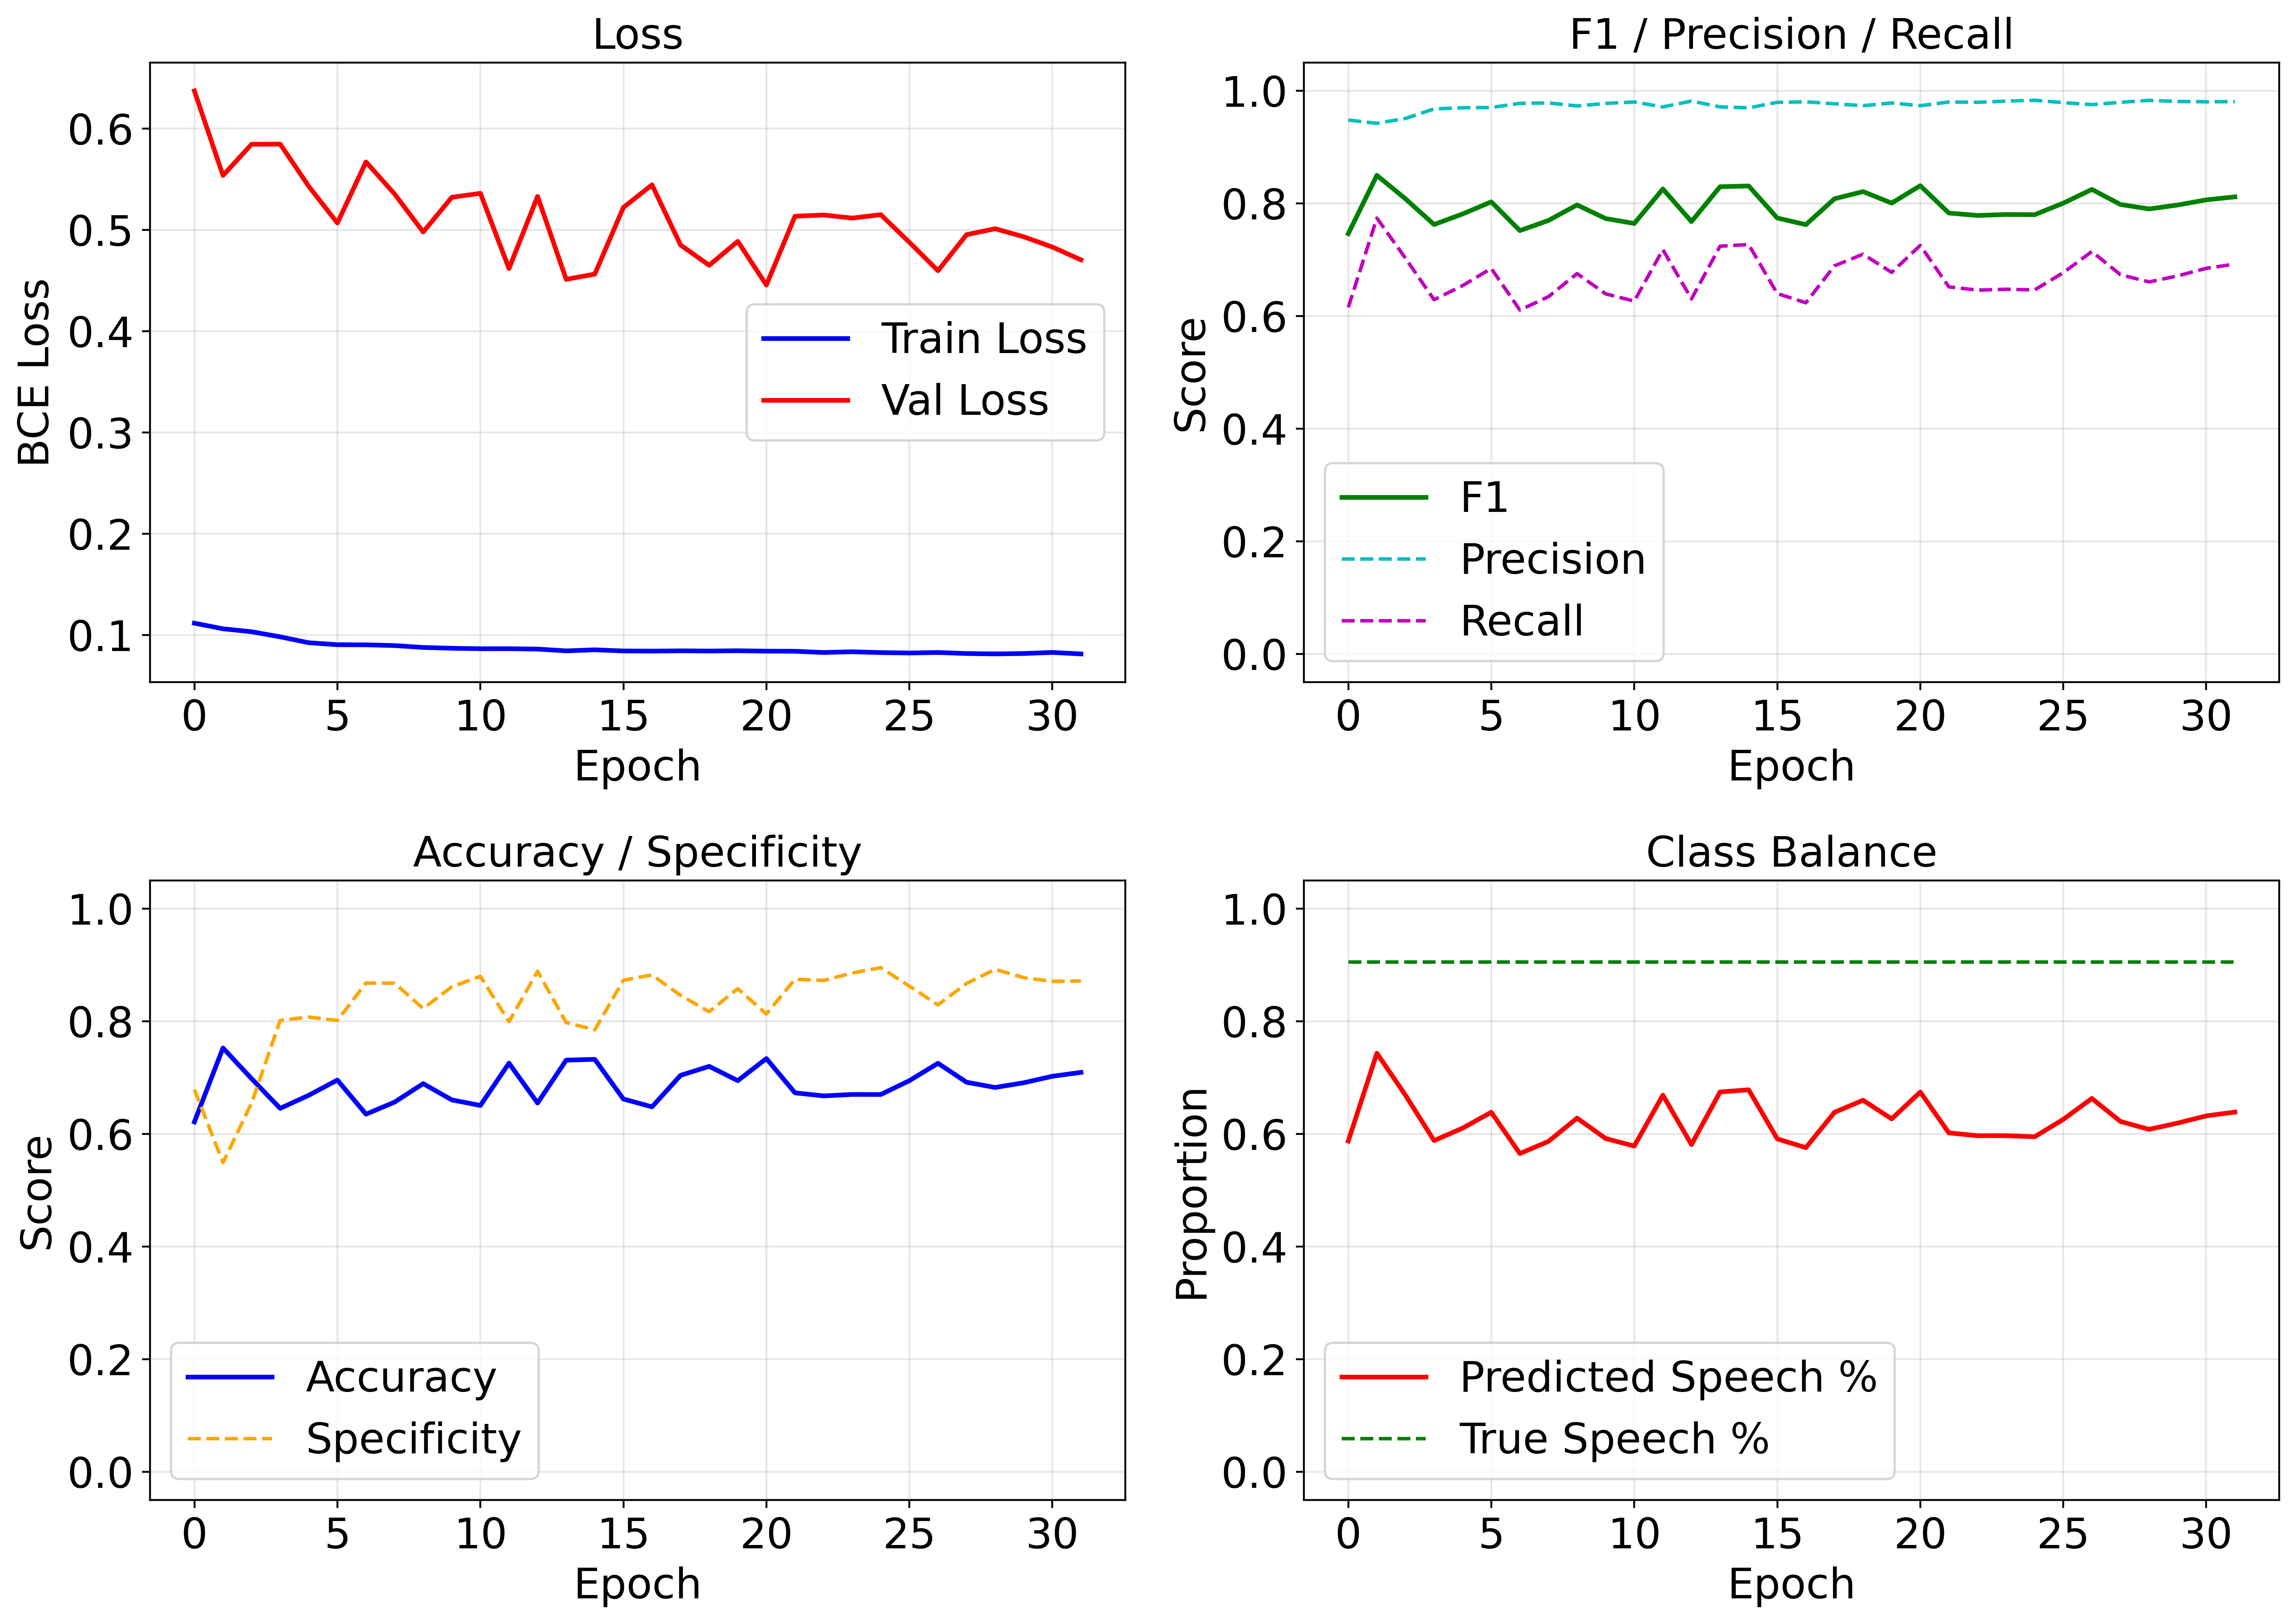

<Figure size 2560x1920 with 0 Axes>

Epoch 33/80:   0%|          | 0/113 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Clean speech duration: 11.24s (179915 samples)
Noise duration: 9.60s (153657 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 11.42s (182650 samples)
Noise duration: 15.49s (247865 samples)
Noise truncated to random frame starting at sample 50286
Clean speech duration: 15.92s (254680 samples)
Noise duration: 10.58s (169356 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 9.61s (153702 samples)
Noise duration: 11.54s (184709 samples)
Noise truncated to random frame starting at sample 20450
Clean speech duration: 13.28s (212508 samples)
Noise duration: 14.79s (236649 samples)
Noise truncated to random frame starting at sample 20743
Clean speech duration: 13.01s (208104 samples)
Noise duration: 16.09s (257471 samples)
Noise truncated to random frame starting at sample 39722
Clean speech duration: 14.18s (226922 samples)
Noise duration: 12.54s (200647 samples)
Noise extended usin

In [ ]:
# %% ------------------------- Cell 6: Enhanced Training (Realistic Labels + Improvements) --------------------------
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

# Initialize model
vad = TinyGRUVAD(32, 16).to(device)
opt = torch.optim.AdamW(vad.parameters(), lr=1e-3, weight_decay=1e-6)

# Check class balance and set weighted loss - IMPROVED: Use ALL training data
print("Checking class balance in training data...")
print("[INFO] Computing class balance from ENTIRE training set (this may take a moment)...")
sample_labels = []

# Sample all batches for accurate class balance (critical for proper weighting)
for i, (_, y, lengths) in enumerate(tqdm(train_dl, desc="Computing class balance")):
    # Only collect valid (non-padded) labels using lengths
    for b in range(y.size(0)):
        valid_length = int(lengths[b].item())
        sample_labels.append(y[b, :valid_length].numpy().ravel())

# Concatenate all valid labels
sample_labels_cat = np.concatenate(sample_labels)
speech_ratio = sample_labels_cat.mean()
print(f"\n[INFO] Training data speech ratio: {speech_ratio:.2%}")
print(f"[INFO] Non-speech ratio: {(1-speech_ratio):.2%}")
print(f"[INFO] Total frames analyzed: {len(sample_labels_cat):,}")

# Weighted loss to balance classes (Graf et al. 2015)
pos_weight = torch.tensor([(1 - speech_ratio) / (speech_ratio + 1e-8)]).to(device)
print(f"Using pos_weight={pos_weight.item():.2f} for class balancing\n")

crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='sum')
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)

bestF1, bestPath = -1.0, repo_root / "models" / "GRU_VAD" / "tiny_vad_best.pth"
bestPath.parent.mkdir(parents=True, exist_ok=True)

# Create directory for saving all best models per epoch
models_dir = repo_root / "models" / "GRU_VAD" / "training_checkpoints"
models_dir.mkdir(parents=True, exist_ok=True)
print(f"[INFO] Checkpoint directory: {models_dir}")

# Create directory for saving training data/graphs
training_data_dir = repo_root / "results" / "GRU_VAD" / "training_data"
training_data_dir.mkdir(parents=True, exist_ok=True)
print(f"[INFO] Training data directory: {training_data_dir}")

# Early stopping configuration
early_stop_patience = 40  # Stop if no improvement for 40 epochs
epochs_without_improvement = 0

# LR warmup function (Vaswani et al. 2017)
def lr_warmup(epoch, warmup_epochs=5, base_lr=1e-3):
    """Linear warmup for first few epochs."""
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    return base_lr

# Prepare live plotting
plt.ion()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax_loss, ax_f1, ax_acc, ax_bal = axes.flatten()

ax_loss.set_title("Loss"); ax_loss.set_xlabel("Epoch"); ax_loss.set_ylabel("BCE Loss"); ax_loss.grid(True, alpha=0.3)
ax_f1.set_title("F1 / Precision / Recall"); ax_f1.set_xlabel("Epoch"); ax_f1.set_ylabel("Score"); ax_f1.grid(True, alpha=0.3)
ax_acc.set_title("Accuracy / Specificity"); ax_acc.set_xlabel("Epoch"); ax_acc.set_ylabel("Score"); ax_acc.grid(True, alpha=0.3)
ax_bal.set_title("Class Balance"); ax_bal.set_xlabel("Epoch"); ax_bal.set_ylabel("Proportion"); ax_bal.grid(True, alpha=0.3)

# Metrics storage
train_losses, val_losses = [], []
f1_scores, prec_scores, rec_scores = [], [], []
acc_scores, spec_scores = [], []
pred_speech_ratios, true_speech_ratios = [], []

print("="*80)
print("ENHANCED TRAINING: Realistic Labels + Gradient Clipping + LR Warmup + Class Balance")
print("="*80)

num_epochs = 80

for epoch in range(1, num_epochs + 1):
    # Apply LR warmup
    current_lr = lr_warmup(epoch, warmup_epochs=5)
    for param_group in opt.param_groups:
        param_group['lr'] = current_lr
    
    # ---------------- Train ----------------
    vad.train()
    Ltr = 0.0
    for x, y, L in tqdm(train_dl, desc=f"Epoch {epoch}/{num_epochs}", leave=False):
        x, y = x.to(device), y.to(device)
        logits, _ = vad(x)
        
        # Mask padded frames
        B, Tmax = logits.size(0), logits.size(1)
        mask = (torch.arange(Tmax, device=L.device)[None, :] < L[:, None]).to(device)
        logits_flat = logits.squeeze(-1)[mask]
        labels_flat = y.squeeze(-1)[mask]
        
        loss = crit(logits_flat, labels_flat) / mask.sum().clamp_min(1.0)
        
        opt.zero_grad()
        loss.backward()
        
        # GRADIENT CLIPPING (Pascanu et al. 2013 - prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(vad.parameters(), max_norm=1.0)
        
        opt.step()
        Ltr += loss.item()
    
    Ltr /= len(train_dl)
    train_losses.append(Ltr)
    
    # ---------------- Validate ----------------
    vad.eval()
    Lval = 0.0
    P, L_all = [], []
    
    with torch.no_grad():
        for x, y, lengths in val_dl:
            x, y = x.to(device), y.to(device)
            logits, _ = vad(x)
            
            # Masked validation loss
            B, Tmax = logits.size(0), logits.size(1)
            mask = (torch.arange(Tmax, device=lengths.device)[None, :] < lengths[:, None]).to(device)
            logits_flat = logits.squeeze(-1)[mask]
            labels_flat = y.squeeze(-1)[mask]
            
            Lval += (nn.functional.binary_cross_entropy_with_logits(
                logits_flat, labels_flat, reduction='sum'
            ) / mask.sum().clamp_min(1.0)).item()
            
            probs = torch.sigmoid(logits).cpu().numpy()
            labs = y.cpu().numpy()
            
            # Collect per-frame predictions
            for b in range(B):
                valid = slice(0, int(lengths[b].item()))
                P.append(probs[b, valid].ravel())
                L_all.append(labs[b, valid].ravel())
    
    Lval /= len(val_dl)
    val_losses.append(Lval)
    
    # Compute metrics
    probs = np.concatenate(P)
    labels = np.concatenate(L_all).astype(int)
    pred = (probs >= 0.5).astype(int)
    
    # Standard metrics
    prec, rec, f1, _ = precision_recall_fscore_support(labels, pred, average="binary", zero_division=0)
    auc = roc_auc_score(labels, probs)
    
    # ENHANCED METRICS
    acc = accuracy_score(labels, pred)
    
    # Specificity (true negative rate)
    tn = ((pred == 0) & (labels == 0)).sum()
    fp = ((pred == 1) & (labels == 0)).sum()
    specificity = tn / (tn + fp + 1e-8)
    
    # Class balance monitoring
    pred_speech_ratio = pred.mean()
    true_speech_ratio = labels.mean()
    
    # Store metrics
    f1_scores.append(f1)
    prec_scores.append(prec)
    rec_scores.append(rec)
    acc_scores.append(acc)
    spec_scores.append(specificity)
    pred_speech_ratios.append(pred_speech_ratio)
    true_speech_ratios.append(true_speech_ratio)
    
    # Update scheduler
    sched.step(Lval)
    
    # ---------------- Save Best Model ----------------
    if f1 > bestF1:
        bestF1 = f1
        torch.save(vad.state_dict(), bestPath)
        
        # Save checkpoint with epoch number
        checkpoint_path = models_dir / f"tiny_vad_epoch_{epoch:03d}_f1_{f1:.4f}.pth"
        torch.save(vad.state_dict(), checkpoint_path)
        
        epochs_without_improvement = 0  # Reset counter
        status = f"[INFO] NEW BEST (F1={f1:.3f}) - Saved epoch {epoch}"
    else:
        epochs_without_improvement += 1
        status = f"[DEBUG] (No improvement: {epochs_without_improvement}/{early_stop_patience})"
    
    # ---------------- Display ----------------
    clear_output(wait=True)
    print(f"Epoch {epoch:2d}/{num_epochs}  LR={current_lr:.1e}  TL={Ltr:.3f}  VL={Lval:.3f}")
    print(f"  PREC={prec:.3f}  REC={rec:.3f}  F1={f1:.3f}  ACC={acc:.3f}")
    print(f"  SPEC={specificity:.3f}  AUC={auc:.3f}  {status}")
    print(f"  Pred Speech: {pred_speech_ratio:.2%}  True Speech: {true_speech_ratio:.2%}")
    
    # Update plots
    for ax in axes.flatten():
        ax.cla()
    
    # Loss plot
    ax_loss.plot(train_losses, "b-", label="Train Loss", linewidth=2)
    ax_loss.plot(val_losses, "r-", label="Val Loss", linewidth=2)
    ax_loss.legend(); ax_loss.set_xlabel("Epoch"); ax_loss.set_ylabel("BCE Loss")
    ax_loss.set_title("Loss"); ax_loss.grid(True, alpha=0.3)
    
    # F1/Precision/Recall plot
    ax_f1.plot(f1_scores, "g-", label="F1", linewidth=2)
    ax_f1.plot(prec_scores, "c--", label="Precision", linewidth=1.5)
    ax_f1.plot(rec_scores, "m--", label="Recall", linewidth=1.5)
    ax_f1.legend(); ax_f1.set_xlabel("Epoch"); ax_f1.set_ylabel("Score")
    ax_f1.set_ylim(-0.05, 1.05); ax_f1.set_title("F1 / Precision / Recall")
    ax_f1.grid(True, alpha=0.3)
    
    # Accuracy/Specificity plot
    ax_acc.plot(acc_scores, "b-", label="Accuracy", linewidth=2)
    ax_acc.plot(spec_scores, "orange", linestyle="--", label="Specificity", linewidth=1.5)
    ax_acc.legend(); ax_acc.set_xlabel("Epoch"); ax_acc.set_ylabel("Score")
    ax_acc.set_ylim(-0.05, 1.05); ax_acc.set_title("Accuracy / Specificity")
    ax_acc.grid(True, alpha=0.3)
    
    # Class balance plot
    ax_bal.plot(pred_speech_ratios, "r-", label="Predicted Speech %", linewidth=2)
    ax_bal.plot(true_speech_ratios, "g--", label="True Speech %", linewidth=1.5)
    ax_bal.legend(); ax_bal.set_xlabel("Epoch"); ax_bal.set_ylabel("Proportion")
    ax_bal.set_ylim(-0.05, 1.05); ax_bal.set_title("Class Balance")
    ax_bal.grid(True, alpha=0.3)
    
    plt.tight_layout()
    display(fig)
    plt.pause(0.001)
    
    # Early stopping (monitor validation F1 improvement)
    if epochs_without_improvement >= early_stop_patience:
        print(f"\n[INFO] Early stopping: No F1 improvement for {early_stop_patience} epochs")
        print(f"       Best F1: {bestF1:.3f} (saved at epoch {epoch - early_stop_patience})")
        break
    
    # Secondary stopping: LR floor (prevents infinite training if patience is too high)
    if sched._last_lr[0] < 1e-5:
        print(f"\n[INFO] LR floor reached: Stopping training")
        break

# Save all training metrics to CSV for later analysis
import pandas as pd
print("\n[INFO] Saving training metrics to CSV...")

metrics_df = pd.DataFrame({
    'epoch': list(range(1, len(train_losses) + 1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'f1_score': f1_scores,
    'precision': prec_scores,
    'recall': rec_scores,
    'accuracy': acc_scores,
    'specificity': spec_scores,
    'pred_speech_ratio': pred_speech_ratios,
    'true_speech_ratio': true_speech_ratios
})

metrics_csv_path = training_data_dir / "training_metrics.csv"
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"[INFO] Metrics saved to: {metrics_csv_path}")

# Save final training plot
fig.savefig(training_data_dir / "training_curves.png", dpi=400, bbox_inches='tight')
print(f"[INFO] Training curves saved to: {training_data_dir / 'training_curves.png'}")

print("\n" + "="*80)
print(" ENHANCED TRAINING COMPLETE!")
print("="*80)
print(f"  Best Validation F1: {bestF1:.3f}")
print(f"  Model saved: {bestPath}")
print(f"  Checkpoints saved in: {models_dir}")
print(f"  Training data saved in: {training_data_dir}")

# Load best model
vad.load_state_dict(torch.load(bestPath, map_location=device))
print(f"  Best model loaded for evaluation.")

In [ ]:
# %% ====================== Cell 6.5: BASELINE VAD COMPARISON ======================
# Compare our GRU-VAD against traditional baseline methods
# Critical for establishing that our approach provides value over simpler methods

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

print("="*80)
print(" [INFO] BASELINE COMPARISON - Traditional VAD Methods")
print("="*80)

def energy_based_vad(signal, fs, frame_len=0.008, hop_len=0.004, threshold_percentile=0.20):
    """Simple energy-based VAD (baseline method).
    
    Reference: ITU-T G.729B Annex B - Voice Activity Detection
    """
    n_fft = int(fs * frame_len)
    hop = int(fs * hop_len)
    
    # Simple frame energy
    frames = []
    for i in range(0, len(signal) - n_fft, hop):
        frame = signal[i:i+n_fft]
        energy = (frame ** 2).sum()
        frames.append(energy)
    
    frames = torch.tensor(frames)
    
    # Percentile-based threshold (same as our label generation)
    sorted_energy = torch.sort(frames)[0]
    noise_floor = sorted_energy[int(threshold_percentile * len(sorted_energy))]
    threshold = noise_floor * 2.0
    
    return (frames > threshold).float()

def zero_crossing_rate_vad(signal, fs, frame_len=0.008, hop_len=0.004, zcr_threshold=0.3):
    """Zero-Crossing Rate based VAD (classical method).
    
    Speech typically has lower ZCR than noise.
    Reference: Rabiner & Sambur (1975) - "An Algorithm for Determining the Endpoints of Isolated Utterances"
    """
    n_fft = int(fs * frame_len)
    hop = int(fs * hop_len)
    
    zcr_list = []
    for i in range(0, len(signal) - n_fft, hop):
        frame = signal[i:i+n_fft]
        # Count zero crossings
        signs = torch.sign(frame)
        zcr = ((signs[:-1] * signs[1:]) < 0).float().mean()
        zcr_list.append(zcr)
    
    zcr_list = torch.tensor(zcr_list)
    
    # Speech has LOWER ZCR, so invert the logic
    return (zcr_list < zcr_threshold).float()

def spectral_entropy_vad(signal, fs, frame_len=0.008, hop_len=0.004, entropy_threshold=0.5):
    """Spectral entropy based VAD.
    
    Speech has structured spectrum (low entropy), noise is more uniform (high entropy).
    Reference: Shen et al. (1998) - "Robust Entropy-based Endpoint Detection"
    """
    n_fft = int(fs * frame_len)
    hop = int(fs * hop_len)
    win = torch.hann_window(n_fft)
    
    entropy_list = []
    for i in range(0, len(signal) - n_fft, hop):
        frame = signal[i:i+n_fft]
        
        # Compute power spectrum
        spec = torch.stft(frame.unsqueeze(0), n_fft, hop, window=win, center=False, return_complex=True)
        power = spec.abs().squeeze() ** 2
        power = power / (power.sum() + 1e-10)  # Normalize to probability
        
        # Compute entropy
        entropy = -(power * torch.log(power + 1e-10)).sum()
        entropy_list.append(entropy)
    
    entropy_list = torch.tensor(entropy_list)
    
    # Normalize entropy to [0, 1]
    entropy_norm = (entropy_list - entropy_list.min()) / (entropy_list.max() - entropy_list.min() + 1e-10)
    
    # Speech has LOW entropy
    return (entropy_norm < entropy_threshold).float()

def wiener_as_vad(signal, fs, frame_len=0.008, hop_len=0.004, eta=0.15, a_dd=0.98, mu=0.98):
    """Wiener-AS VAD based on log-likelihood ratio.
    
    Uses a priori SNR estimation and decision-directed approach.
    This is the VAD from Scalart & Filho (1996) used in wiener_as.m
    
    Reference: Scalart & Filho (1996) - "Speech enhancement based on a priori 
               signal to noise estimation", ICASSP
    """
    n_fft = int(fs * frame_len)
    hop = int(fs * hop_len)
    win = torch.hann_window(n_fft)
    U = (win @ win) / n_fft  # normalization factor
    
    # Estimate initial noise from first 120ms (assuming noise only)
    len_120ms = int(fs * 0.120)
    first_120ms = signal[:min(len_120ms, len(signal))]
    
    # Estimate noise power spectrum using Welch's method with 50% overlap
    noise_ps = torch.zeros(n_fft)
    n_subframes = max(1, int(len(first_120ms) / (n_fft // 2)) - 1)
    n_start = 0
    
    for j in range(n_subframes):
        if n_start + n_fft > len(first_120ms):
            break
        noise_frame = first_120ms[n_start:n_start + n_fft] * win
        noise_fft = torch.fft.fft(noise_frame, n=n_fft)
        noise_ps += (noise_fft.abs() ** 2) / (n_fft * U)
        n_start += n_fft // 2
    
    noise_ps = noise_ps / max(1, n_subframes)
    
    # Process frames for VAD
    vad_decisions = []
    G_prev = torch.ones(n_fft)
    posteri_prev = torch.ones(n_fft)
    
    n_frames = max(1, (len(signal) - n_fft) // hop + 1)
    
    for j in range(n_frames):
        n_start = j * hop
        if n_start + n_fft > len(signal):
            break
            
        noisy_frame = signal[n_start:n_start + n_fft] * win
        noisy_fft = torch.fft.fft(noisy_frame, n=n_fft)
        noisy_ps = (noisy_fft.abs() ** 2) / (n_fft * U)
        
        # A posteriori SNR
        posteri = noisy_ps / (noise_ps + 1e-16)
        posteri_prime = torch.clamp(posteri - 1.0, min=0.0)
        
        # A priori SNR (decision-directed)
        if j == 0:
            priori = a_dd + (1 - a_dd) * posteri_prime
        else:
            priori = a_dd * (G_prev ** 2) * posteri_prev + (1 - a_dd) * posteri_prime
        
        # Log-likelihood ratio for VAD
        log_sigma_k = posteri * priori / (1 + priori) - torch.log1p(priori)
        vad_decision = log_sigma_k.mean().item()
        
        # VAD threshold
        if vad_decision < eta:
            # Noise only frame - update noise estimate
            noise_ps = mu * noise_ps + (1 - mu) * noisy_ps
            vad_decisions.append(0)
        else:
            # Speech frame
            vad_decisions.append(1)
        
        # Update state for next frame
        G_prev = torch.sqrt(priori / (1.0 + priori + 1e-16))
        posteri_prev = posteri
    
    return torch.tensor(vad_decisions, dtype=torch.float32)

def mband_vad(signal, fs, frame_len=0.008, hop_len=0.004):
    """Multi-band spectral subtraction VAD.
    
    Uses relative spectral difference for VAD decision.
    This is the VAD from noiseupdt() function in mband.m
    
    Reference: Kamath & Loizou (2002) - "A multi-band spectral subtraction 
               method for enhancing speech corrupted by colored noise", ICASSP
    """
    n_fft = int(fs * frame_len)
    hop = int(fs * hop_len)
    win = torch.hann_window(n_fft)
    
    # Estimate initial noise from first 6 frames
    n_noise_frames = 6
    noise_ps = torch.zeros(n_fft)
    
    for j in range(n_noise_frames):
        n_start = j * n_fft
        if n_start + n_fft > len(signal):
            break
        noise_frame = signal[n_start:n_start + n_fft] * win
        noise_fft = torch.fft.fft(noise_frame, n=n_fft)
        noise_ps += (noise_fft.abs() ** 2)
    
    noise_mag = torch.sqrt(noise_ps / max(1, n_noise_frames))
    
    # Process frames for VAD
    vad_decisions = []
    n_frames = max(1, (len(signal) - n_fft) // hop + 1)
    
    for j in range(n_frames):
        n_start = j * hop
        if n_start + n_fft > len(signal):
            break
            
        frame = signal[n_start:n_start + n_fft] * win
        frame_fft = torch.fft.fft(frame, n=n_fft)
        frame_mag = frame_fft.abs()
        
        # Compute relative spectral variance indicator
        x_var = frame_mag ** 2
        n_var = noise_mag ** 2
        
        # Avoid division by zero and log of zero
        ratio = x_var / (n_var + 1e-16)
        rti = ratio - torch.log10(ratio.clamp(min=1e-16)) - 1
        judge_value = rti.mean().item()
        
        # Threshold-based decision
        threshold = 0.4 if j == 0 else 0.45
        
        if judge_value > threshold:
            # Speech detected
            vad_decisions.append(1)
        else:
            # Silence detected - update noise estimate
            noise_mag = torch.sqrt(0.9 * noise_mag**2 + 0.1 * frame_mag**2)
            vad_decisions.append(0)
    
    return torch.tensor(vad_decisions, dtype=torch.float32)

# Evaluate baselines on validation set
print("\n[INFO] Evaluating baseline methods on validation set...\n")

baseline_results = {}

# Define all baseline methods
baseline_methods = [
    ("Energy-Based VAD", energy_based_vad),
    ("Zero-Crossing Rate VAD", zero_crossing_rate_vad),
    ("Spectral Entropy VAD", spectral_entropy_vad),
    ("Wiener-AS VAD (Scalart 1996)", wiener_as_vad),
    ("Multi-Band VAD (Kamath 2002)", mband_vad)
]

for baseline_name, baseline_fn in baseline_methods:
    print(f"Testing: {baseline_name}...")
    
    all_preds = []
    all_labels = []
    
    # Use subset of validation pairs for speed
    eval_subset = val_pairs[:min(100, len(val_pairs))]
    
    for i, (noise_file, clean_file) in enumerate(tqdm(eval_subset, desc=baseline_name, leave=False)):
        try:
            # Load audio
            cw, nw, noisy, fs = preprocess_audio(Path(clean_file), Path(noise_file), 16_000, snr_db=0)
            
            # Get ground truth labels
            _, labels = mix_and_extract(noisy, cw, fs)
            labels_np = labels.squeeze().numpy()
            
            # Get baseline predictions
            preds = baseline_fn(noisy.squeeze(), fs)
            preds_np = preds.numpy()
            
            # Align lengths (take minimum)
            min_len = min(len(preds_np), len(labels_np))
            all_preds.append(preds_np[:min_len])
            all_labels.append(labels_np[:min_len])
            
        except Exception as e:
            print(f"  Warning: Error processing sample {i}: {e}")
            continue
    
    if len(all_preds) == 0:
        print(f"   {baseline_name}: Failed to process any samples\n")
        continue
    
    # Concatenate and compute metrics
    all_preds_cat = np.concatenate(all_preds).astype(int)
    all_labels_cat = np.concatenate(all_labels).astype(int)
    
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels_cat, all_preds_cat, average='binary', zero_division=0)
    acc = accuracy_score(all_labels_cat, all_preds_cat)
    
    baseline_results[baseline_name] = {
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'accuracy': acc
    }
    
    print(f"   {baseline_name}: F1={f1:.3f}, Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}\n")

# Evaluate our GRU-VAD on the same validation subset
print("Testing: GRU-VAD (Our Method)...")
vad.eval()
gru_preds = []
gru_labels = []

with torch.no_grad():
    for i, (noise_file, clean_file) in enumerate(tqdm(eval_subset, desc="GRU-VAD", leave=False)):
        try:
            cw, nw, noisy, fs = preprocess_audio(Path(clean_file), Path(noise_file), 16_000, snr_db=0)
            feats, labels = mix_and_extract(noisy, cw, fs)
            
            logits, _ = vad(feats.to(device))
            probs = torch.sigmoid(logits).cpu().numpy().squeeze()
            preds = (probs >= 0.5).astype(int)
            labels_np = labels.squeeze().numpy().astype(int)
            
            min_len = min(len(preds), len(labels_np))
            gru_preds.append(preds[:min_len])
            gru_labels.append(labels_np[:min_len])
        except Exception as e:
            print(f"  Warning: Error processing sample {i}: {e}")
            continue

gru_preds_cat = np.concatenate(gru_preds)
gru_labels_cat = np.concatenate(gru_labels)

gru_prec, gru_rec, gru_f1, _ = precision_recall_fscore_support(gru_labels_cat, gru_preds_cat, average='binary', zero_division=0)
gru_acc = accuracy_score(gru_labels_cat, gru_preds_cat)

baseline_results["GRU-VAD (proposed)"] = {
    'precision': gru_prec,
    'recall': gru_rec,
    'f1': gru_f1,
    'accuracy': gru_acc
}

print(f"   GRU-VAD (proposed): F1={gru_f1:.3f}, Acc={gru_acc:.3f}, Prec={gru_prec:.3f}, Rec={gru_rec:.3f}\n")

# Create comparison table
print("="*80)
print(" [INFO] BASELINE COMPARISON RESULTS")
print("="*80)

import pandas as pd
comparison_df = pd.DataFrame(baseline_results).T
comparison_df = comparison_df.sort_values('f1', ascending=False)

print("\n" + comparison_df.to_string())
print("\n" + "="*80)

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

x = np.arange(len(baseline_results))
width = 0.2

metrics = ['precision', 'recall', 'f1', 'accuracy']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    values = [baseline_results[name][metric] for name in baseline_results.keys()]
    ax.bar(x + i*width, values, width, label=metric.capitalize(), color=color, alpha=0.8)

ax.set_xlabel('VAD Method')
ax.set_ylabel('Score')
ax.set_title(f'VAD Method Comparison (Validation Set, n={len(eval_subset)} samples)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(baseline_results.keys(), rotation=25, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.05)

plt.tight_layout()

# Save comparison
baseline_dir = repo_root / "results" / "GRU_VAD" / "baseline_comparison"
baseline_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(baseline_dir / "baseline_comparison.png", dpi=400, bbox_inches='tight')
comparison_df.to_csv(baseline_dir / "baseline_comparison.csv")

print(f"[INFO] Baseline comparison saved to: {baseline_dir}")

# Compute improvement over best baseline
best_baseline_f1 = max([v['f1'] for k, v in baseline_results.items() if k != "GRU-VAD (proposed)"])
best_baseline_name = [k for k, v in baseline_results.items() if v['f1'] == best_baseline_f1][0]
improvement = ((gru_f1 - best_baseline_f1) / (best_baseline_f1 + 1e-16)) * 100

print(f"\n[INFO] Best baseline: {best_baseline_name} (F1={best_baseline_f1:.3f})")
print(f"[INFO] GRU-VAD improvement over best baseline: {improvement:+.1f}%")

if improvement > 10:
    print("[INFO]  Strong improvement - Neural approach justified!")
elif improvement > 5:
    print("[INFO]  Moderate improvement - Neural approach shows promise")
elif improvement > 0:
    print("[INFO]  Modest improvement - Consider computational cost vs. benefit")
else:
    print("[WARNING]  Neural method underperforming - Investigate issues or use baselines")
    print(f"           Traditional methods (especially {best_baseline_name}) may be more suitable")

plt.show()

print("\n" + "="*80)
print(" [SUMMARY] Baseline Methods Included:")
print("="*80)
print("  1. Energy-Based VAD - ITU-T G.729B inspired")
print("  2. Zero-Crossing Rate VAD - Rabiner & Sambur (1975)")
print("  3. Spectral Entropy VAD - Shen et al. (1998)")
print("  4. Wiener-AS VAD - Scalart & Filho (1996) - Used in wiener_as.m")
print("  5. Multi-Band VAD - Kamath & Loizou (2002) - Used in mband.m")
print("  6. GRU-VAD (proposed) - Deep learning approach")
print("="*80)


In [ ]:
# %% ====================== Cell 7: FINAL TEST SET EVALUATION ======================
# IMPORTANT: Run this cell ONLY ONCE after training is complete!
# This provides an unbiased estimate of model performance on held-out data.
# 
# Reference: Goodfellow et al. (2016) "Deep Learning" - Section 5.3
# "The test set should be used only once, to evaluate the final chosen model."

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print(" [INFO] FINAL TEST SET EVALUATION")
print("="*80)
print("\n[INFO] Creating test dataset...")

# Create test dataset (never seen during training/validation)
test_ds = LiveMixDataset(test_pairs)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=8, collate_fn=collate_pad, pin_memory=True)

print(f"[INFO] Test set size: {len(test_pairs)} pairs")
print(f"[INFO] Evaluating best model (F1={bestF1:.3f} on validation)...\n")

# Ensure model is in eval mode and using best weights
vad.eval()
vad.load_state_dict(torch.load(bestPath, map_location=device))

# Collect predictions
test_probs_list, test_labels_list = [], []
test_loss = 0.0

with torch.no_grad():
    for x, y, lengths in tqdm(test_dl, desc="Testing"):
        x, y = x.to(device), y.to(device)
        logits, _ = vad(x)
        
        # Compute masked loss
        B, Tmax = logits.size(0), logits.size(1)
        mask = (torch.arange(Tmax, device=lengths.device)[None, :] < lengths[:, None]).to(device)
        logits_flat = logits.squeeze(-1)[mask]
        labels_flat = y.squeeze(-1)[mask]
        
        test_loss += (nn.functional.binary_cross_entropy_with_logits(
            logits_flat, labels_flat, reduction='sum'
        ) / mask.sum().clamp_min(1.0)).item()
        
        probs = torch.sigmoid(logits).cpu().numpy()
        labs = y.cpu().numpy()
        
        # Collect per-frame predictions (only valid frames)
        for b in range(B):
            valid_len = int(lengths[b].item())
            test_probs_list.append(probs[b, :valid_len].ravel())
            test_labels_list.append(labs[b, :valid_len].ravel())

test_loss /= len(test_dl)

# Concatenate all predictions
test_probs_cat = np.concatenate(test_probs_list)
test_labels_cat = np.concatenate(test_labels_list).astype(int)
test_pred = (test_probs_cat >= 0.5).astype(int)

# Compute comprehensive metrics
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    test_labels_cat, test_pred, average="binary", zero_division=0
)
test_auc = roc_auc_score(test_labels_cat, test_probs_cat)
test_acc = accuracy_score(test_labels_cat, test_pred)

# Confusion matrix
cm = confusion_matrix(test_labels_cat, test_pred)
tn, fp, fn, tp = cm.ravel()
test_specificity = tn / (tn + fp + 1e-8)
test_sensitivity = tp / (tp + fn + 1e-8)  # Same as recall

# Print results
print("\n" + "="*80)
print(" [INFO] TEST SET RESULTS")
print("="*80)
print(f"\n  Loss:        {test_loss:.4f}")
print(f"  Accuracy:    {test_acc:.4f}")
print(f"  Precision:   {test_prec:.4f}")
print(f"  Recall:      {test_rec:.4f}")
print(f"  F1 Score:    {test_f1:.4f}")
print(f"  Specificity: {test_specificity:.4f}")
print(f"  AUC-ROC:     {test_auc:.4f}")

print(f"\n  Speech frames predicted:     {test_pred.mean():.2%}")
print(f"  Speech frames actual:        {test_labels_cat.mean():.2%}")

print("\n" + "-"*80)
print(" Detailed Classification Report")
print("-"*80)
print(classification_report(
    test_labels_cat, test_pred, 
    target_names=['Non-Speech', 'Speech'],
    digits=4
))

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix (counts)
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=True)
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_title(f'Confusion Matrix (Test Set)\nF1={test_f1:.3f}, Acc={test_acc:.3f}')
ax1.set_xticklabels(['Non-Speech', 'Speech'])
ax1.set_yticklabels(['Non-Speech', 'Speech'])

# Confusion matrix (normalized)
ax2 = axes[1]
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=ax2, cbar=True)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_title(f'Normalized Confusion Matrix\nSpec={test_specificity:.3f}, Sens={test_sensitivity:.3f}')
ax2.set_xticklabels(['Non-Speech', 'Speech'])
ax2.set_yticklabels(['Non-Speech', 'Speech'])

plt.tight_layout()

# Save confusion matrix plot
test_results_dir = repo_root / "results" / "GRU_VAD" / "test_evaluation"
test_results_dir.mkdir(parents=True, exist_ok=True)
confusion_matrix_path = test_results_dir / "confusion_matrix.png"
fig.savefig(confusion_matrix_path, dpi=400, bbox_inches='tight')
print(f"[INFO] Confusion matrix saved to: {confusion_matrix_path}")

plt.show()

# Save test metrics to CSV
import pandas as pd
test_metrics_df = pd.DataFrame({
    'metric': ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'specificity', 'sensitivity', 'auc_roc', 'speech_pred_ratio', 'speech_true_ratio'],
    'value': [test_loss, test_acc, test_prec, test_rec, test_f1, test_specificity, test_sensitivity, test_auc, test_pred.mean(), test_labels_cat.mean()]
})
test_metrics_path = test_results_dir / "test_metrics.csv"
test_metrics_df.to_csv(test_metrics_path, index=False)
print(f"[INFO] Test metrics saved to: {test_metrics_path}")

# Save confusion matrix values
cm_df = pd.DataFrame(cm, index=['Non-Speech', 'Speech'], columns=['Non-Speech', 'Speech'])
cm_path = test_results_dir / "confusion_matrix_values.csv"
cm_df.to_csv(cm_path)
print(f"[INFO] Confusion matrix values saved to: {cm_path}")

# Compare validation vs test performance
print("\n" + "="*80)
print(" [INFO] VALIDATION vs TEST COMPARISON")
print("="*80)
print(f"  Metric          Validation    Test       Delta")
print(f"  {'─'*50}")
print(f"  F1 Score        {bestF1:.4f}        {test_f1:.4f}     {(test_f1-bestF1):+.4f}")
print(f"  Accuracy        N/A           {test_acc:.4f}")
print(f"  AUC-ROC         N/A           {test_auc:.4f}")
print("="*80)

# Interpretation
if abs(test_f1 - bestF1) < 0.05:
    print("\n[INFO] Good generalization: Test F1 within 5% of validation F1")
elif test_f1 < bestF1 - 0.05:
    print("\n[WARNING] Slight overfitting: Test F1 lower than validation (may need regularization)")
else:
    print("\n[INFO] Test F1 exceeds validation! Model generalizes well.")

print("\n" + "="*80)
print(" [INFO] TEST EVALUATION COMPLETE")
print("="*80)


In [ ]:
# %% =================== Cell 8: ROC/PR Curve Analysis & Optimal Threshold ===================
# Systematic threshold analysis using ROC and Precision-Recall curves
# This determines the optimal operating point for the VAD system

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

print("="*80)
print(" [INFO] ROC & PRECISION-RECALL CURVE ANALYSIS")
print("="*80)

# Collect predictions and labels on validation set
print("\n[INFO] Collecting predictions on validation set...")
vad.eval()
val_probs_list = []
val_labels_list = []

with torch.no_grad():
    for x, y, lengths in tqdm(val_dl, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        logits, _ = vad(x)
        probs = torch.sigmoid(logits).cpu().numpy()
        labs = y.cpu().numpy()
        
        # Collect per-frame predictions (only valid frames)
        B = x.size(0)
        for b in range(B):
            valid_len = int(lengths[b].item())
            val_probs_list.append(probs[b, :valid_len].ravel())
            val_labels_list.append(labs[b, :valid_len].ravel())

val_probs = np.concatenate(val_probs_list)
val_labels = np.concatenate(val_labels_list).astype(int)

print(f"[INFO] Total validation frames: {len(val_probs):,}")

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(val_labels, val_probs)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(val_labels, val_probs)
avg_precision = average_precision_score(val_labels, val_probs)

# Find optimal threshold using Youden's J statistic (maximizes TPR - FPR)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold_roc = roc_thresholds[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]

# Find optimal threshold using F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_f1_idx = np.argmax(f1_scores)
optimal_threshold_f1 = pr_thresholds[optimal_f1_idx] if optimal_f1_idx < len(pr_thresholds) else 0.5
optimal_precision = precision[optimal_f1_idx]
optimal_recall = recall[optimal_f1_idx]
optimal_f1 = f1_scores[optimal_f1_idx]

print("\n" + "="*80)
print(" [INFO] OPTIMAL THRESHOLD ANALYSIS")
print("="*80)
print(f"\nUsing ROC (Youden's J):")
print(f"  Optimal Threshold: {optimal_threshold_roc:.3f}")
print(f"  TPR (Sensitivity): {optimal_tpr:.3f}")
print(f"  FPR:               {optimal_fpr:.3f}")
print(f"  Specificity:       {1-optimal_fpr:.3f}")

print(f"\nUsing F1 Score:")
print(f"  Optimal Threshold: {optimal_threshold_f1:.3f}")
print(f"  Precision:         {optimal_precision:.3f}")
print(f"  Recall:            {optimal_recall:.3f}")
print(f"  F1 Score:          {optimal_f1:.3f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: ROC Curve
ax1 = axes[0, 0]
ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
ax1.plot(optimal_fpr, optimal_tpr, 'ro', markersize=10, label=f'Optimal (θ={optimal_threshold_roc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([-0.02, 1.02])
ax1.set_ylim([-0.02, 1.02])

# Plot 2: Precision-Recall Curve
ax2 = axes[0, 1]
ax2.plot(recall, precision, 'g-', linewidth=2, label=f'PR curve (AP = {avg_precision:.3f})')
ax2.plot(optimal_recall, optimal_precision, 'ro', markersize=10, label=f'Optimal (θ={optimal_threshold_f1:.2f})')
ax2.axhline(y=val_labels.mean(), color='k', linestyle='--', linewidth=1, label='Baseline (random)')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([-0.02, 1.02])
ax2.set_ylim([-0.02, 1.02])

# Plot 3: Threshold vs Metrics
ax3 = axes[1, 0]
# Use PR thresholds for plotting
thresholds_plot = np.linspace(0, 1, 100)
tpr_interp = np.interp(thresholds_plot, roc_thresholds, tpr)
fpr_interp = np.interp(thresholds_plot, roc_thresholds, fpr)

ax3.plot(thresholds_plot, tpr_interp, 'b-', linewidth=2, label='TPR (Sensitivity)')
ax3.plot(thresholds_plot, 1 - fpr_interp, 'r-', linewidth=2, label='TNR (Specificity)')
ax3.axvline(x=optimal_threshold_roc, color='purple', linestyle='--', linewidth=2, label=f'Optimal θ={optimal_threshold_roc:.2f}')
ax3.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, label='Default θ=0.5')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Rate')
ax3.set_title('TPR & TNR vs Threshold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1.05])

# Plot 4: Example validation sample with optimal threshold
ax4 = axes[1, 1]
exN, exC = val_pairs[0]
cw, nw, noisy, fs = preprocess_audio(Path(exC), Path(exN), 16_000, snr_db=0)
f, l = mix_and_extract(noisy, cw, fs, frame_len=0.008, hop_len=0.004)

with torch.no_grad():
    logits, _ = vad(f.to(device))
    p = torch.sigmoid(logits).squeeze().cpu().numpy()
    l = l.squeeze().cpu().numpy()

time_axis = np.arange(len(p)) * 0.004
ax4.plot(time_axis, p, 'b-', label="P(speech)", linewidth=2)
ax4.plot(time_axis, l, 'g--', label="Ground Truth", alpha=0.6, linewidth=2)
ax4.axhline(y=optimal_threshold_f1, color='r', linestyle='--', alpha=0.7, label=f'Optimal θ={optimal_threshold_f1:.2f}')
ax4.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Default θ=0.5')
ax4.set_xlabel('Time (seconds)')
ax4.set_ylabel('Probability')
ax4.set_title('Example: VAD Predictions with Optimal Threshold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim([-0.05, 1.05])

plt.tight_layout()

# Save ROC/PR analysis
roc_pr_dir = repo_root / "results" / "GRU_VAD" / "threshold_analysis"
roc_pr_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(roc_pr_dir / "roc_pr_analysis.png", dpi=400, bbox_inches='tight')
print(f"\n[INFO] ROC/PR curves saved to: {roc_pr_dir / 'roc_pr_analysis.png'}")

# Save threshold analysis data
import pandas as pd
threshold_data = pd.DataFrame({
    'method': ['Youden_J (ROC)', 'Max F1 (PR)', 'Default'],
    'threshold': [optimal_threshold_roc, optimal_threshold_f1, 0.5],
    'tpr_sensitivity': [optimal_tpr, optimal_recall, np.nan],
    'fpr': [optimal_fpr, np.nan, np.nan],
    'specificity': [1-optimal_fpr, np.nan, np.nan],
    'precision': [np.nan, optimal_precision, np.nan],
    'f1_score': [np.nan, optimal_f1, np.nan]
})
threshold_data.to_csv(roc_pr_dir / "optimal_thresholds.csv", index=False)
print(f"[INFO] Threshold data saved to: {roc_pr_dir / 'optimal_thresholds.csv'}")

plt.show()

print("\n" + "="*80)
print(" [RECOMMENDATION] Use threshold = {:.2f} for best F1 score".format(optimal_threshold_f1))
print("="*80)


In [ ]:
# %% =================== Cell 9: Computational Profiling & Resource Analysis ===================
# Critical for validating "hearing-aid friendly" claims
# Measure: inference time, memory usage, model size, real-time factor

import time
import os

print("="*80)
print(" [INFO] COMPUTATIONAL PROFILING")
print("="*80)

# 1. Model Size Analysis
model_size_bytes = os.path.getsize(bestPath)
model_size_kb = model_size_bytes / 1024
model_size_mb = model_size_kb / 1024

print(f"\n[MODEL SIZE]")
print(f"  File size: {model_size_kb:.2f} KB ({model_size_mb:.3f} MB)")

# Count parameters
total_params = sum(p.numel() for p in vad.parameters())
trainable_params = sum(p.numel() for p in vad.parameters() if p.requires_grad)

print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Memory footprint (float32): {total_params * 4 / 1024:.2f} KB")


# Save profiling results
profiling_dir = repo_root / "results" / "GRU_VAD" / "computational_profiling"
profiling_dir.mkdir(parents=True, exist_ok=True)

profiling_data = {
    'model_size_kb': model_size_kb,
    'total_parameters': total_params,
    'trainable_parameters': trainable_params
}

profiling_df = pd.DataFrame([profiling_data])
profiling_df.to_csv(profiling_dir / "computational_profile.csv", index=False)
print(f"\n[INFO] Profiling results saved to: {profiling_dir}")